### Importing Necessary Libraries

In [1]:
pip install pydicom

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 21.3 MB/s eta 0:00:00


In [2]:
# Importing necessary libraries

from pathlib import Path
import pydicom as pydc
import matplotlib.pyplot as plt

In this colab notebook, i'll be working with dicom files.

Here, we will be using the CT images provided by cancer imaging archives. 

The images we got here only contain single slice.

i.e. we will be exploring dicom in 2D setting.

### Reading the DICOM file

In order to read DICOM file, we will be using ***`read_file`*** function provided by `pydicom`.

In [5]:
# Reading the dicom file.

dicom_file = pydc.read_file('dicom_data/ID_0095_AGE_0071_CONTRAST_0_CT.dcm')

In [6]:
# Explore dicom header

print(dicom_file)

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 196
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.3.6.1.4.1.14519.5.2.1.6450.9002.578794045870805618560456155391
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.40.0.13.1.1.1
(0002, 0013) Implementation Version Name         SH: 'dcm4che-1.4.34'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'AXIAL']
(0008, 0012) Instance Creation Date              DA: '19980313'
(0008, 0013) Instance Creation Time              TM: '141826'
(0008, 0016) SOP Class UID                       UI: CT Image Storage
(0008, 0018) SOP Insta

We can see that the DICOM header consists of device information, patient information, UIDs' and image information.

We can extract information such as the number of pixel rows and columns in an image.

We can obtain the number of rows and columns in identifiers or UID `(0028, 0010)` and `(0028, 0011)` respectively.

But in order to access those attributes from headers, we need to pass them in hexadecimal format as shown below.

In [7]:
# Get the number of pixel rows

dicom_file[0x0028, 0x0010]

(0028, 0010) Rows                                US: 512

We can also access the number of pixel rows using `Rows` attribute.

In [8]:
dicom_file.Rows

512

### Getting the Actual image out of dicom file

To get the actual image we will use `pixel_array` attribute.

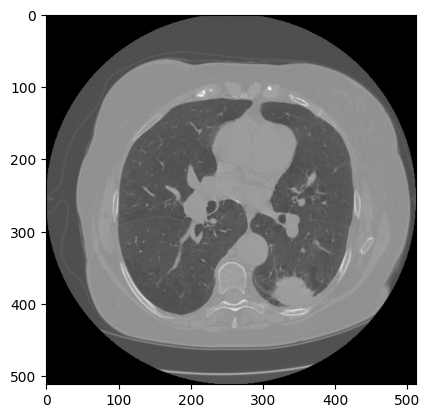

In [9]:
# Getting the actual image

ct = dicom_file.pixel_array

# Visualize the ct image

plt.figure()
plt.imshow(ct, cmap = "gray")

Let's now look at real world example of 3D medical image.

For this purpose, we will be using head MRI scans.

In [10]:
# Define the path to head MRI data

# For this, we define path object to the root path.

path_to_head_mri = Path("ST000000/")

We can create something like a file handler for the files inside the path object using `.glob()`  function. Using the `.glob()` function, we can also selct files with specific extensions but here we donot have any specific extension in our files. So, we extract all of them.


Also, we need to keep in minde that the `.glob()` function returns a generator. So, we need to create a list to be able to inspect the elements.

In [12]:
#  Get all files

all_files = list(path_to_head_mri.glob("*"))

Now, let's check `all_files`.

In [13]:
# Checking all_files

all_files

[PosixPath('ST000000/MR000003'),
 PosixPath('ST000000/MR000004'),
 PosixPath('ST000000/MR000000'),
 PosixPath('ST000000/MR000002'),
 PosixPath('ST000000/MR000001')]

Here, we can see that we have paths to all the data in our directory.

We can now use `.read_file()` function from `pydicom` to look at all the files and append them to a list.

In [14]:
# Create empty list
mri_data = []

for path in all_files:
  data = pydc.read_file(path)
  mri_data.append(data)


Observing the `all_files` list above, we see that the dicom files are unordered. Because of that we may have unordered data in our list "`mri_data`".

We can check the order of data using `.SliceLocation' attribute.

In [15]:
# Checking the order
for slice in mri_data:
  print(slice.SliceLocation)

206.797699272813
174.041300962232
0.0
39.9999990534569
19.9999995267284


We can verify that the MRI slice are not in order. In order to sort them in order, we can use pythons' `sorted` function.

In [16]:
# Sort the list on the basis of individual SliceLocation
mri_data_ordered = sorted(mri_data, key=lambda slice: slice.SliceLocation)

In [17]:
# Checking order again for confirmation

for slice in mri_data_ordered:
  print(slice.SliceLocation)

0.0
19.9999995267284
39.9999990534569
174.041300962232
206.797699272813


We can now extract the sorted dicom data pixel arrays and store them in a list.

In [18]:
# Extracting the pixel_array
full_volume = []
for slice in mri_data_ordered:
  full_volume.append(slice.pixel_array)

Visualizing the ordered 3D image.

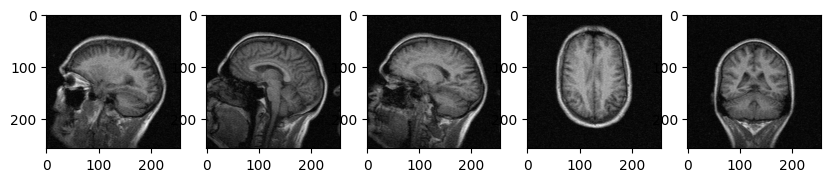

In [23]:
fig, axis = plt.subplots(1, 5, figsize=(10,10))

slice_counter = 0
for i in range(5):
  axis[i].imshow(full_volume[slice_counter], cmap = 'gray')
  slice_counter += 1

We have successfully accessed 2D and 3D data and that was little bit hectic. 

### SimpleITK

We also do have a tool for doing this : ***SimpleITK***

***SimpleITK*** provides functionality to automatically detect and read dicom files without manual processes.

Start by importing SimpleITK.

In [24]:
pip install SimpleITK

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 12.8 MB/s eta 0:00:00


In [25]:
import SimpleITK as sitk

Now, we grab the `series_id` by calling `sitk.ImageSeriesReader.GetGDCMSeriesIDs(str(root_path))`.

As ***SimpleITK*** is library built on *C++*, it cannot handle  path objects. So, we need to convert the path object to the string.

In [26]:
series_ids = sitk.ImageSeriesReader.GetGDCMSeriesIDs(str(path_to_head_mri))
print(series_ids)

('1.3.46.670589.11.0.0.11.4.2.0.12098.5.4500.2015011413252331688',)


`sitk.ImageSeriesReader.GetGDCMSeriesIDs(str(root_path))` gave us the tuple containing a single `series_id`.

Now, we extract the series filenames `sitk.ImageSeriesReader.GetGDCMSeriesFileNames(str(root_path), series_ids[0])`.

In [27]:
series_file_names = sitk.ImageSeriesReader.GetGDCMSeriesFileNames(str(path_to_head_mri), series_ids[0])

Let's take a look at `series_file_names`.

In [28]:
series_file_names

('ST000000/MR000002',
 'ST000000/MR000001',
 'ST000000/MR000000',
 'ST000000/MR000004',
 'ST000000/MR000003')

We can see that all the files are sorted already.

Now, we can call the reader using function `sitk.ImageSeriesReader()`.

We pass our filenames to our series reader and call `.SetFileNames(series_file_names)`

In [30]:
series_reader = sitk.ImageSeriesReader()
series_reader.SetFileNames(series_file_names)

Finally, we load our image data by calling `series_reader.Execute()`

In [32]:
image_data = series_reader.Execute()

Now, we convert the obtained sitk image to numpy array.

This can be done by `.GetArrayFromImage(image_data)` function.

In [33]:
head_mri = sitk.GetArrayFromImage(image_data)

In [34]:
# Shape of head_mri
head_mri.shape

(5, 256, 256)

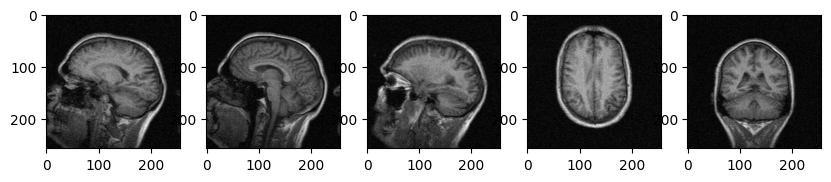

In [35]:
# Observing image
fig, axis = plt.subplots(1, 5, figsize=(10,10))

slice_counter = 0
for i in range(5):
  axis[i].imshow(head_mri[slice_counter], cmap = 'gray')
  slice_counter += 1

### NIfTI Format

NIfTI is another way of storing medical data and it is used because it is easier to work than the DICOM format in many ways.

We can start by converting DICOM images into NIfTI format by the help of `docim2nifti` package.

In [36]:
pip install dicom2nifti

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 59.2 MB/s eta 0:00:00


In [41]:
import dicom2nifti

Here we donot need any path object and we can directly use the path string.

In [42]:
path_to_dicom = 'ST000000/'

Now, we are ready to use `.convert_directory()` function to convert dicom files to nifti.

In [43]:
dicom2nifti.convert_directory(path_to_dicom, ".")

### Reading and Exploring NIfTI files

In [44]:
# Import necessary libraries
import matplotlib.pyplot as plt
import nibabel as nib

The NIfTI file we created above consists of the complete 3D head MRI scan.

We can load it by using `.load()` method.

In [45]:
nifti = nib.load("301_t1w_ffe.nii.gz")

In order to inspect the metadata, header information and other attributes, We can just print the nifti.

In [46]:
print(nifti)

<class 'nibabel.nifti1.Nifti1Image'>
data shape (256, 32, 256)
affine: 
[[-8.97858143e-01  2.05476537e-01  9.69570130e-03  1.10738663e+02]
 [ 3.02598923e-02  5.98943520e+00 -4.38681319e-02 -9.60733795e+01]
 [ 1.11809419e-02  2.90593058e-01  8.97313535e-01 -1.35675827e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
metadata:
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b''
dim_info        : 0
dim             : [  3 256  32 256   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : uint16
bitpix          : 16
slice_start     : 0
pixdim          : [-1.         0.8984375  6.         0.8984375  1.         1.
  1.         1.       ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 2
cal

In order to access specific header attribute, we can do following:

In [47]:
nifti.header['qoffset_x']

array(110.73866, dtype=float32)

In [48]:
nifti.shape

(256, 32, 256)

In [49]:
image_array = nifti.get_fdata()

In [54]:
import numpy as np

In [55]:
img = np.transpose(image_array, (0, 2, 1))

In [56]:
img.shape

(256, 256, 32)

In [57]:
img

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

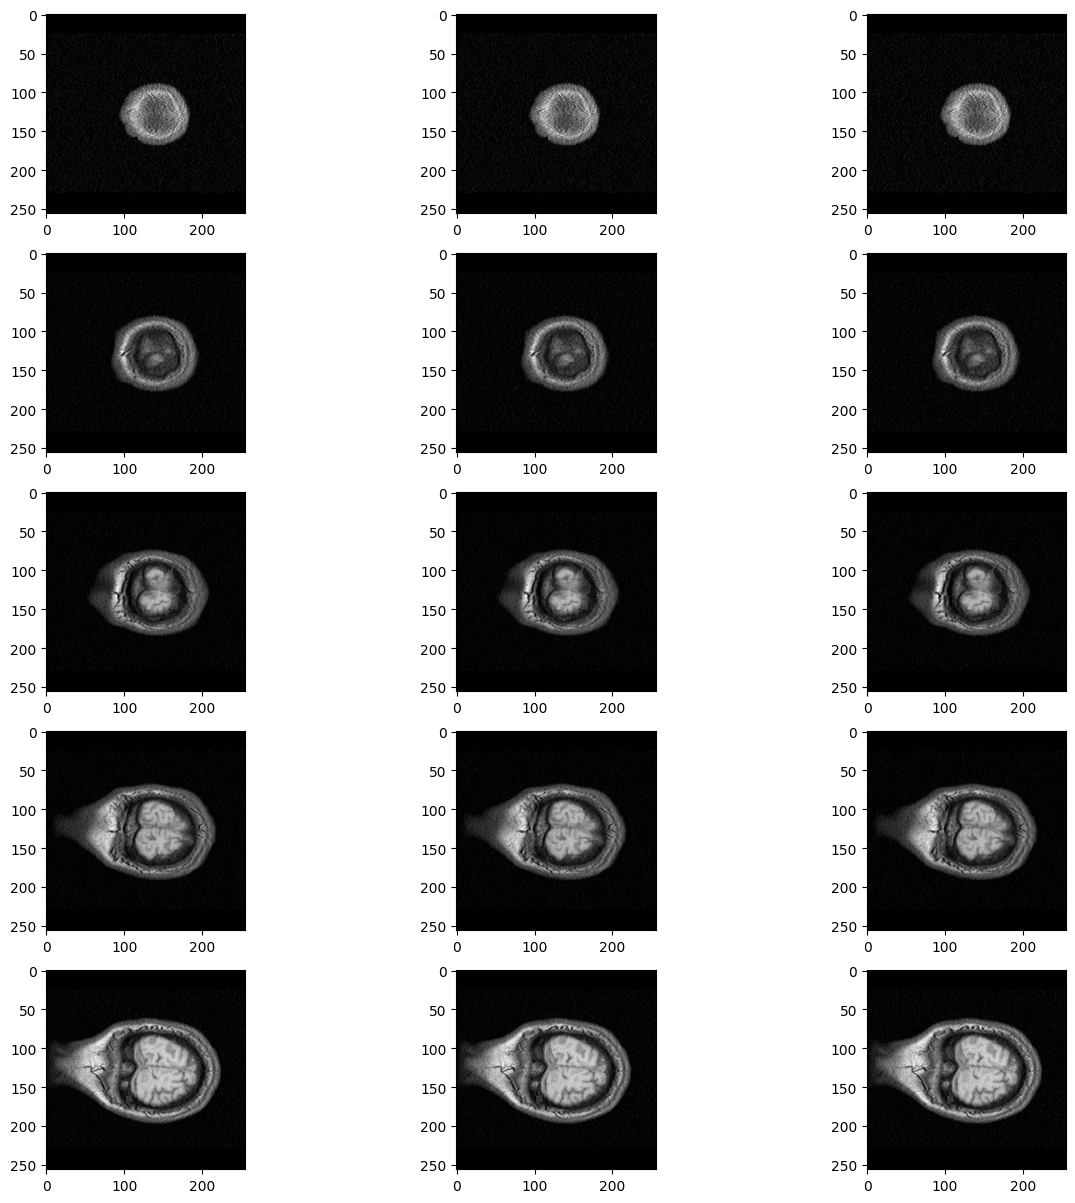

In [61]:
fig, axis = plt.subplots(5, 3, figsize=(15, 15))

slice_counter = 0
for i in range(5):
  for j in range(3):
      axis[i][j].imshow(img[:, :, slice_counter], cmap = 'gray')
  slice_counter += 1
